# Практическое задание по теме 2. Временные ряды

In [1]:
import numpy as np 
import pandas as pd 

import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_in_business/Lesson_2/'

Обозначения:

* p - глубина истории, сколько измерений назад учитываем в моделях
* h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

### Задание 1.
Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [3]:
file_name = 'my_PJME_MW.csv'
data = pd.read_csv(PATH + file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data.shape)
data.head(2)

(145374, 13)


,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0


In [4]:
TARGET_NAME = 'PJME_MW'

### 1. EDA

In [5]:
def plot_target(data, title_str, stat=True):
    if stat:
        DF_ct = sm.tsa.stattools.adfuller(data['PJME_MW'].values, regression='ct')
        DF_ctt = sm.tsa.stattools.adfuller(data['PJME_MW'].values, regression='ctt')
        print(f'Augmented Dickey–Fuller тест: {round(DF_ct[1], 3)}, {round(DF_ctt[1], 3)}')    
    
    plt.figure(figsize =(20, 3))
    plt.plot( data.index, data[TARGET_NAME], 'b' )
    plt.title(title_str, size=14)
    plt.xlabel('Время')
    plt.ylabel('MW')
    plt.show()

Augmented Dickey–Fuller тест: 0.0, 0.0


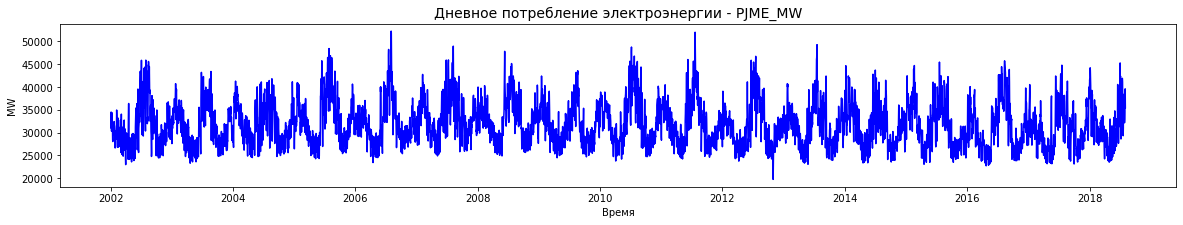

In [6]:
data = data.resample('D').mean()
title_str = 'Дневное потребление электроэнергии - PJME_MW'
plot_target(data, title_str)

Augmented Dickey–Fuller тест: 0.0, 0.0


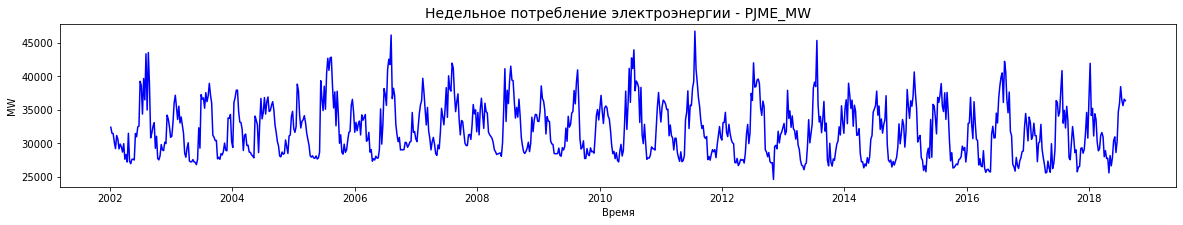

In [7]:
data_w = data.resample('W').mean()
title_str = 'Недельное потребление электроэнергии - PJME_MW'
plot_target(data_w, title_str)

Augmented Dickey–Fuller тест: 0.258, 0.445


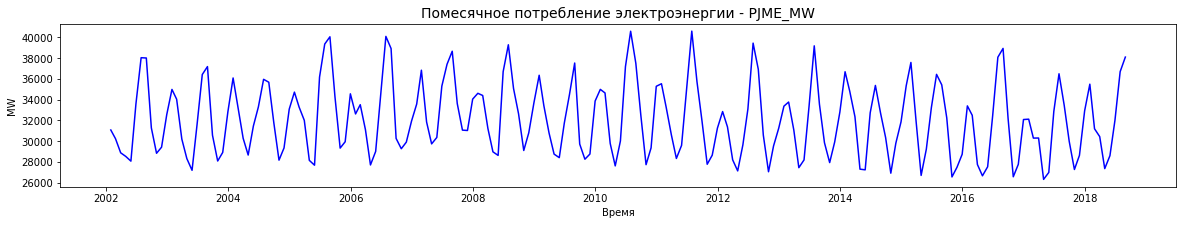

In [8]:
data_m = data.resample('M').mean()
title_str = 'Помесячное потребление электроэнергии - PJME_MW'
plot_target(data_m, title_str)

Augmented Dickey–Fuller тест: 0.996, 0.001


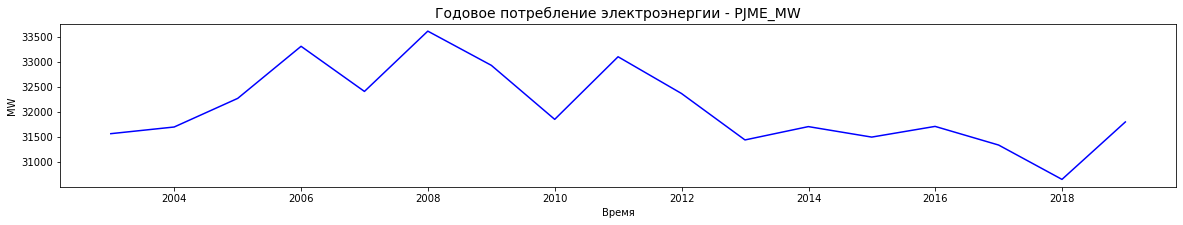

In [9]:
data_y = data.resample('Y').mean()
title_str = 'Годовое потребление электроэнергии - PJME_MW'
plot_target(data_y, title_str)

Согласно коэффициентам ADF, дневные и недельные и годовые средние потребления энергии являются стационарными, месячные средние - не явлются стационарными. 

#### Первые разности.

In [10]:
def first_diff(data, title_str, lag=1):
    data_diff = data.copy()    
    data_diff.loc[lag:, 'PJME_MW'] = data['PJME_MW'].values[lag:]-data['PJME_MW'].values[:-lag]
    plot_target(data_diff[1:], title_str)

Augmented Dickey–Fuller тест: 0.0, 0.0


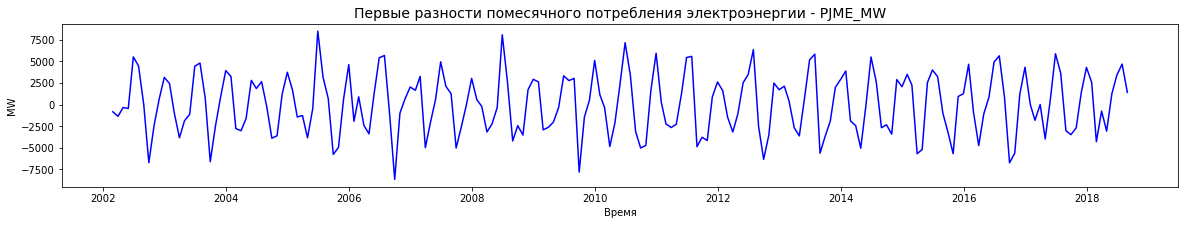

In [11]:
title_str = 'Первые разности помесячного потребления электроэнергии - PJME_MW'
first_diff(data_m, title_str)

Augmented Dickey–Fuller тест показал, что это интегрированный ряд, т.е. лаги изменения потребления энергии стационарны на месячных интервалах. Соответственно у модели есть две составляющие: сезонность потребления энергии и стационарные колебания вокруг этой компоненты.

In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]]           # first value is same as series
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i - 1])
    return np.array(result)

In [13]:
def plot_smoothing(data, w=3, k=0.15):
    ar_exp_1 = exponential_smoothing(data[TARGET_NAME], k)
    moving_avg = data[TARGET_NAME].rolling(window=w).mean()
    data_diff = data[TARGET_NAME] - ar_exp_1
    
    DF_ct = sm.tsa.stattools.adfuller(data[TARGET_NAME] - ar_exp_1, regression = 'ct')
    DF_ctt = sm.tsa.stattools.adfuller(data[TARGET_NAME] - ar_exp_1, regression = 'ctt')
    print(f'Augmented Dickey–Fuller тест: {round(DF_ct[1], 3)}, {round(DF_ctt[1], 3)}')

    plt.figure(figsize=(20, 6))
    plt.plot(data[TARGET_NAME], label='исходный ряд')
    plt.plot(moving_avg, label="скользящие средние");
    plt.plot(data.index, ar_exp_1, color='r', label="экспоненциальное сглаживание");
    plt.plot(data_diff, color='g', label="без тренда по экспоненциальному сглаживанию");

    plt.xlabel('time')
    plt.ylabel('MW')
    plt.legend()
    plt.title('Потребление Энергии 2002-2018', size=14)
    plt.show()

Augmented Dickey–Fuller тест: 0.009, 0.016


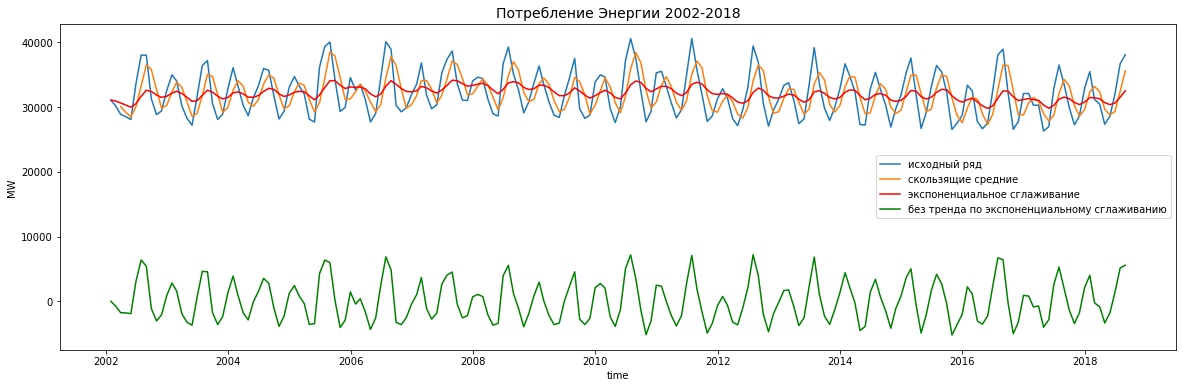

In [14]:
plot_smoothing(data_m)

### 2. Генерация новых признаков

AR - Авторегрессионная модель, с параметром р - глубина регрессии. 
В качестве признаков будем использовать измерения, которые делали в р предшествующие моменты времени.

In [15]:
def feature_engineering(data, exp_smoothing_coef, p=3):
    df = pd.DataFrame(data[TARGET_NAME], columns=[TARGET_NAME])
    # AR
    for i in range(1, p + 1):
        col_name = 't' + str(i)
        df.loc[i:, col_name] = df[TARGET_NAME][:-i].values
        
    # exponential smoothing
    for k in exp_smoothing_coef:
        col_name = 'exp_' + str(k)
        df.loc[:, col_name] = exponential_smoothing(df[TARGET_NAME], k)
        
    # diff 1st order
    df.loc[1:, 'diff_1'] = df[TARGET_NAME][:-1].values - df[TARGET_NAME][1:].values
    
    # diff 2nd order
    df.loc[1:, 'diff_2'] = df['diff_1'][:-1].values - df['diff_1'][1:].values

    return df.fillna(0)

In [16]:
exp_smoothing_coef = [0.05, 0.15, 0.25]
p = 5
df = feature_engineering(data, exp_smoothing_coef, p)
df.head(7)

,PJME_MW,t1,t2,t3,t4,t5,exp_0.05,exp_0.15,exp_0.25,diff_1,diff_2
Date,,,,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000,0.000000
2002-01-02,34261.541667,31080.739130,0.000000,0.000000,0.000000,0.000000,31239.779257,31557.859511,31875.939764,-3180.802536,0.000000
2002-01-03,34511.875000,34261.541667,31080.739130,0.000000,0.000000,0.000000,31403.384044,32000.961834,32534.923573,-250.333333,-2930.469203
2002-01-04,33715.458333,34511.875000,34261.541667,31080.739130,0.000000,0.000000,31518.987759,32258.136309,32830.057263,796.416667,-1046.750000
2002-01-05,30405.125000,33715.458333,34511.875000,34261.541667,31080.739130,0.000000,31463.294621,31980.184613,32223.824198,3310.333333,-2513.916667
2002-01-06,30323.583333,30405.125000,33715.458333,34511.875000,34261.541667,31080.739130,31406.309057,31731.694421,31748.763981,81.541667,3228.791667
2002-01-07,33333.833333,30323.583333,30405.125000,33715.458333,34511.875000,34261.541667,31502.685270,31972.015258,32145.031319,-3010.250000,3091.791667


### 3. Модель

In [17]:
def train_test_split(data, split_date, h=1):
    train = data[data.index.get_level_values('Date') < split_date]
    test = data[data.index.get_level_values('Date') >= split_date]

    X_train = train.iloc[:-h,:]    
    X_test = test.iloc[:-h,:]
    
    y_train = train[TARGET_NAME].values[h:]
    y_test = test[TARGET_NAME].values[h:]
    
    return X_train, X_test, y_train, y_test

In [18]:
def mean_absolute_percentage_error(y_true, y_pred):     
    err = (np.array(y_true) - np.array(y_pred)) / np.array(y_true)
    return np.mean(np.abs(err)) * 100

In [19]:
def plot_prediction():    
    plt.figure( figsize=(20, 4))
    plt.xlabel('Время')
    plt.ylabel(TARGET_NAME)
    plt.plot(X_test.index, y_pred, label='y_pred')
    plt.plot(X_test.index, y_test, label='y_test')
    plt.title(f'{TARGET_NAME} прогноз, h = {h}', size=14)

    plt.legend()
    plt.show()

In [20]:
split_date = '2016-08-02'
h = 1
X_train, X_test, y_train, y_test = train_test_split(df, split_date, h)

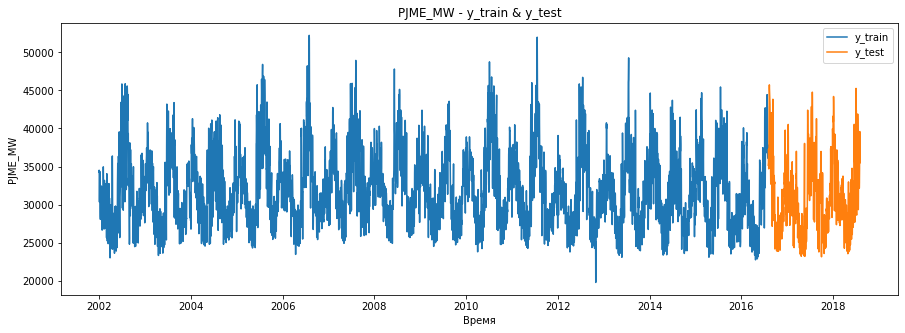

In [21]:
plt.figure( figsize=( 15, 5 ))
plt.xlabel('Время')
plt.ylabel(TARGET_NAME)
plt.plot(X_train.index, y_train, label='y_train' )
plt.plot(X_test.index, y_test, label='y_test')
plt.title(f'{TARGET_NAME} - y_train & y_test' )
plt.legend()
plt.show()

In [22]:
model = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=30)

mean absolute percentage error: 5.62%


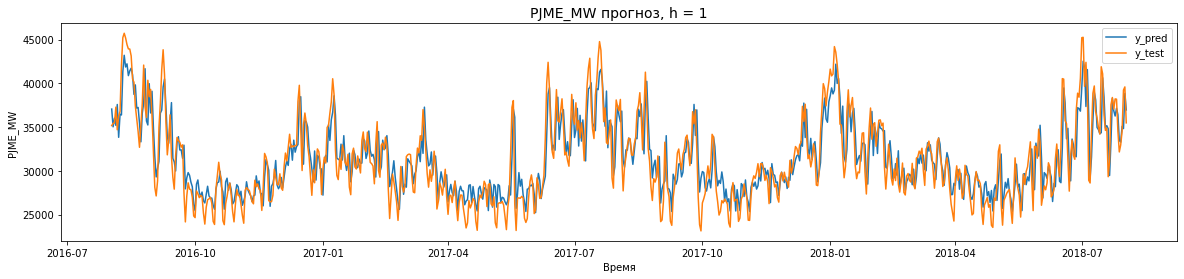

In [23]:
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

err = mean_absolute_percentage_error(y_test, y_pred)
print(f'mean absolute percentage error: {round(err, 2)}%')

plot_prediction()

mean absolute percentage error: 10.25%


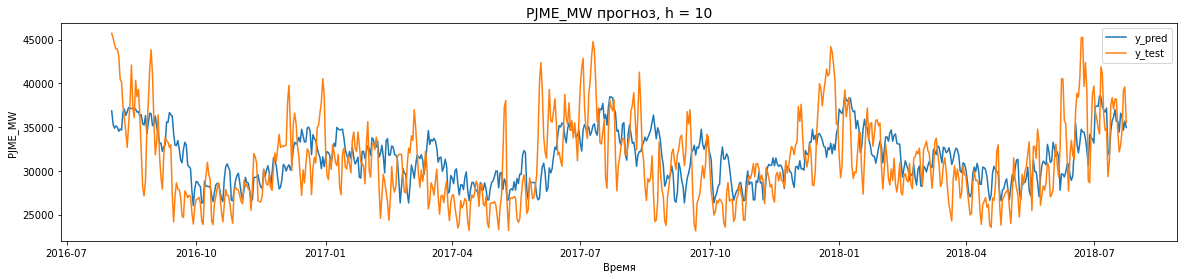

In [24]:
h = 10
X_train, X_test, y_train, y_test = train_test_split(df, split_date, h)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

err = mean_absolute_percentage_error(y_test, y_pred)
print(f'mean absolute percentage error: {round(err, 2)}%')

plot_prediction()

### Задание 2.
Оцените ошибки моделей из п.1 .

Модель авторегрессии с горизонтом прогноза на один шаг вперед (h = 1) дает ошибку 5.62%. При h = 10 ошибка составлет 10.25%

### Задание 3.
Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [25]:
n = 14
error_log = []
for h in range(1, n+1):
    X_train, X_test, y_train, y_test = train_test_split(df, split_date, h)
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)

    err = mean_absolute_percentage_error(y_test, y_pred)
    error_log.append(err) 
    
h_results = pd.DataFrame([[h for h in range(1, n+1)], error_log], index=['h', 'err']).T  

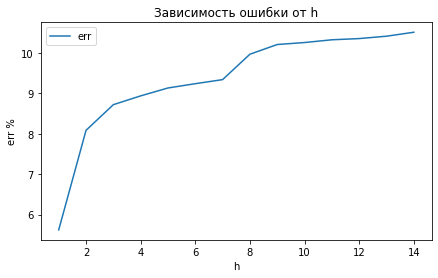

In [26]:
plt.figure( figsize=(7, 4))
plt.xlabel('h')
plt.ylabel('err %')
plt.plot(h_results.h, h_results.err, label='err' )
plt.title('Зависимость ошибки от h')

plt.legend()
plt.show()

Модель авторегрессии с горизонтом прогноза на один шаг вперед (h = 1) дает ошибку 5.62%. При увеличим интервала прогноза ошибка возрастает. При горизонте прогноза h = 2 модель выдает ошибку 8.08%. Потом темпы роста ошибки cущественно замедляются. При h = 10 ошибка составлет 10.25%, а при h = 14 ошибка увеличилась всего до 10.51%.

### Задание 4. 
Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):
* а) Изменение температуры за окном :).
* б) Количество денег, которые тратят покупатели в интернет магазине.
* в) Вес растущего котенка.
* г) Прирост объема деревьев в лесу от времени

Стационарность предполагает постоянство:
* математического ожидания, 
* дисперсии, 
* автоковариацию стационарного ряда с лагом L, 
* коэффициента автокорреляция стационарного ряда с лагом L

На длинных промежутках времени у всех пречисленных случаев математичкое ожидание не является постоянным. Соответственно, мы имеем дело с нестационарными временными рядами. Но можно выделить какие-то сравнительно небольшие промежутки времени, когда можно допустить постоянство мат. ожидания и выполнение остальных трех условий, например, в течение часа. 
* Таким образом, будут ли выполняться условия стационарности зависит от выбраной шкалы времени.

Итак, на больших промежутках времени:

a) нестационарный ряд с трендом - все говорят о потеплении :), сезоном - зима, весна, лето, осень и циклом - день, ночь.

б) нестационарный ряд 
* с трендом - все больше покупок совершается в интернете, 
* сезоном - Новогодние праздники, 23 февраля, 8 марта, Пасхальная неделя, майские праздники и т.д, 
* циклом - в ночные часы покупок меньше, чем в дневные и вечерние, да и ассортимент, скорее всего, отличается.

в) нестационарный ряд
* с трендом - котенок растет, а взрослых котов мы не обсуждаем.
* сезоном - утром до еды вес котенка ниже, чем накануне вечером (закон сохнанения массы - что-то же он выдыхал всю ночь)
* циклом - в течение дня до еды вес котенка ниже, чем после еды.

г) нестационарный ряд
* с трендом - объем деревьев растет, 
* сезоном - летом объем увеличивается больше, чем зимой 
* циклом - я не ботаник, конечно, но наверное, днем деревья от солнца набирают больше энергии, чем ночью от луны :). 